In [1]:
import os
import xarray as xr

folder_path =  "IMD"
imd_data = list()
for i in os.listdir(folder_path):
  path = os.path.join(folder_path, i)
  imd_data.append( path)
  



In [2]:
imd_data[0]

'IMD\\IMD_2017_regridded_pptn.nc'

In [3]:
import xarray as xr
import pandas as pd



# Function to extract data from a single file
def extract_data(file_path):
    ds = xr.open_dataset(file_path)
    extracted = ds.sel(
        LATITUDE=slice(19.125, 19.375,),
        LONGITUDE=slice(72.625,  72.875)
    )
    return extracted.RAINFALL

# Extract data from all files
extracted_data_list = [extract_data(file) for file in imd_data]

# Combine the extracted data
combined_data = xr.concat(extracted_data_list, dim='TIME')

# Convert to DataFrame if needed
df = combined_data.to_dataframe().reset_index()

# Print the first few rows to verify
print(df.head())

# Save to CSV if needed
df.to_csv('combined_rainfall_data.csv', index=False)

# Or save as a new NetCDF file
combined_data.to_netcdf('combined_rainfall_data.nc')

        TIME  LATITUDE  LONGITUDE  RAINFALL
0 2017-01-01    19.125     72.625       NaN
1 2017-01-01    19.125     72.875       0.0
2 2017-01-01    19.375     72.625       NaN
3 2017-01-01    19.375     72.875       0.0
4 2017-01-02    19.125     72.625       NaN


In [4]:
import xarray as xr
import pandas as pd
import numpy as np

# Function to calculate distance between two lat/lon points (Haversine formula)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c  # Distance in kilometers

# Target location
target_lat = 19.124151
target_lon = 72.895641
radius_km = 50  # Define a radius (in kilometers) within which to extract points

# Function to extract data from a single file
def extract_data(file_path):
    ds = xr.open_dataset(file_path)
    
    # Get the latitudes and longitudes
    latitudes = ds['LATITUDE']
    longitudes = ds['LONGITUDE']
    
    # Create an empty mask
    mask = xr.DataArray(np.zeros((len(latitudes), len(longitudes)), dtype=bool), 
                        dims=["LATITUDE", "LONGITUDE"], 
                        coords={"LATITUDE": latitudes, "LONGITUDE": longitudes})
    
    # Apply the haversine distance function and create the mask
    for lat in latitudes:
        for lon in longitudes:
            distance = haversine(target_lat, target_lon, lat, lon)
            if distance <= radius_km:
                mask.loc[dict(LATITUDE=lat, LONGITUDE=lon)] = True
    
    # Use the mask to filter the dataset
    extracted = ds.where(mask, drop=True)
    return extracted.RAINFALL

# Extract data from all files
extracted_data_list = [extract_data(file) for file in imd_data]

# Combine the extracted data
combined_data = xr.concat(extracted_data_list, dim='TIME')

# Convert to DataFrame if needed
df = combined_data.to_dataframe().reset_index()

# Print the first few rows to verify
print(df.head())

# Save to CSV if needed
df.to_csv('combined_rainfall_data.csv', index=False)

# Or save as a new NetCDF file
combined_data.to_netcdf('combined_rainfall_data.nc')


        TIME  LATITUDE  LONGITUDE  RAINFALL
0 2017-01-01    18.875     72.625       NaN
1 2017-01-01    18.875     72.875       0.0
2 2017-01-01    18.875     73.125       0.0
3 2017-01-01    19.125     72.625       NaN
4 2017-01-01    19.125     72.875       0.0


In [5]:
len(df)






13149

In [23]:
df.head()

,TIME,LATITUDE,LONGITUDE,RAINFALL
0,2017-01-01,18.875,72.625,NaN
1,2017-01-01,18.875,72.875,0.0
2,2017-01-01,18.875,73.125,0.0
3,2017-01-01,19.125,72.625,NaN
4,2017-01-01,19.125,72.875,0.0


In [24]:
df["RAINFALL"].max()

312.15621185302734

In [25]:
df["RAINFALL"].mean()

np.float64(9.69436584994698)

In [26]:
df.describe()

,TIME,LATITUDE,LONGITUDE,RAINFALL
count,13149,13149.000000,13149.000000,8766.000000
mean,2019-01-01 00:00:00,19.125000,72.875000,9.694366
min,2017-01-01 00:00:00,18.875000,72.625000,0.000000
25%,2018-01-01 00:00:00,18.875000,72.625000,0.000000
50%,2019-01-01 00:00:00,19.125000,72.875000,0.000000
75%,2020-01-01 00:00:00,19.375000,73.125000,5.069757
max,2020-12-31 00:00:00,19.375000,73.125000,312.156212
std,NaN,0.204132,0.204132,26.805346


In [27]:
df["RAINFALL"] = df["RAINFALL"].fillna(0)

In [28]:
%matplotlib inline

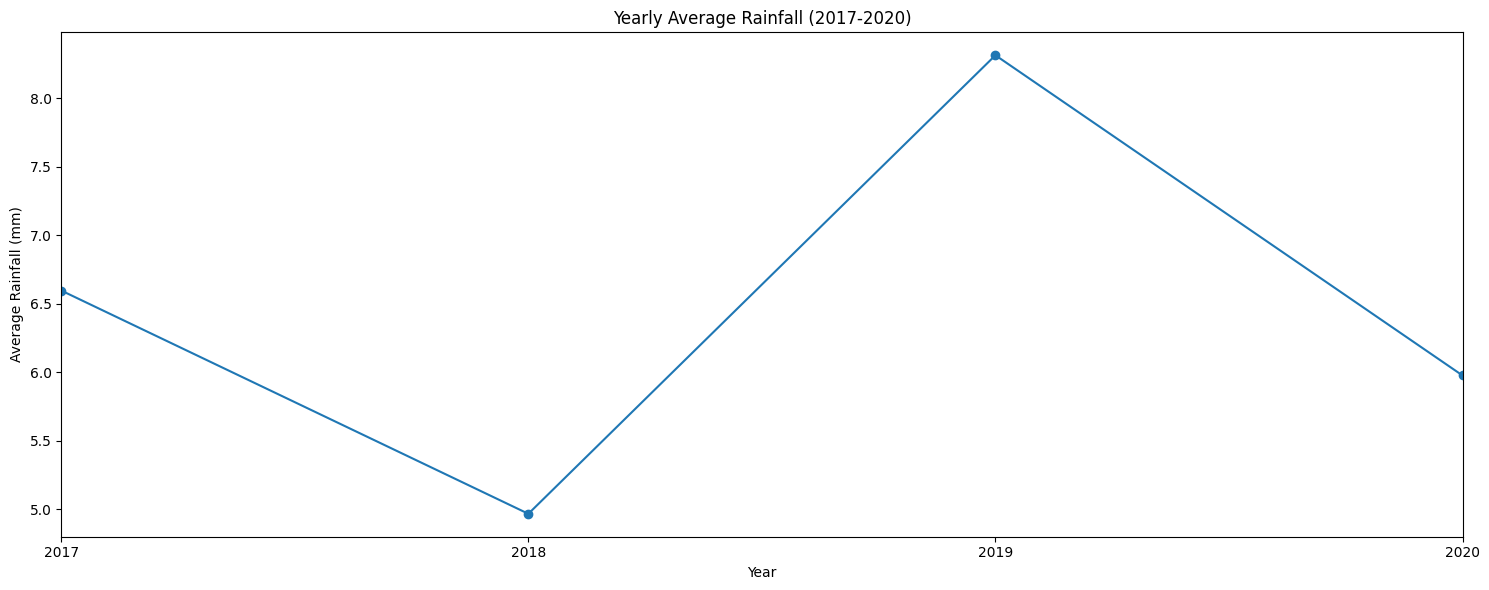

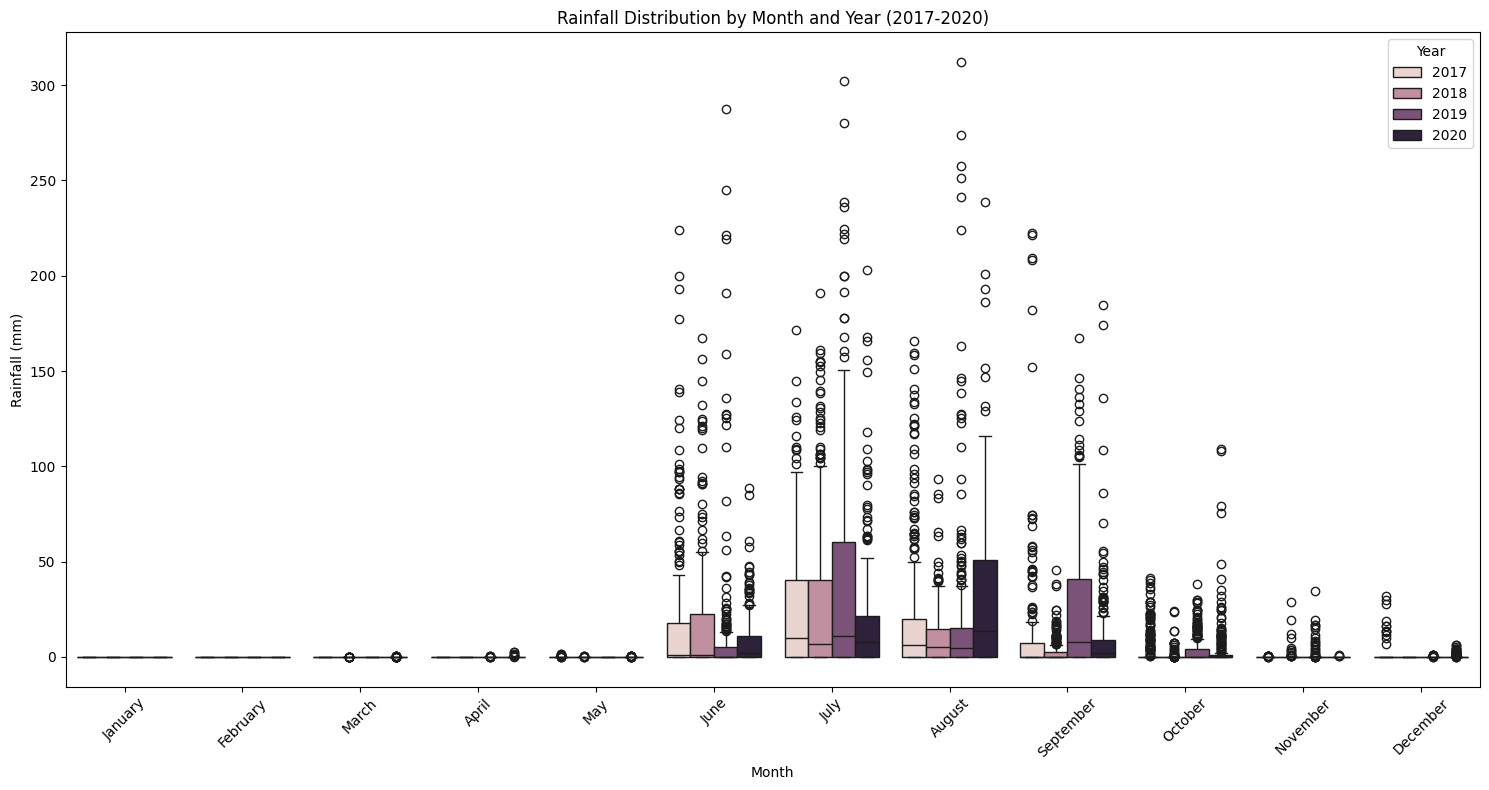

C:\Users\dsmat\AppData\Local\Temp\ipykernel_25072\314979159.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seasonal_avg = df.groupby(['Year', 'Season'])['RAINFALL'].mean().unstack()


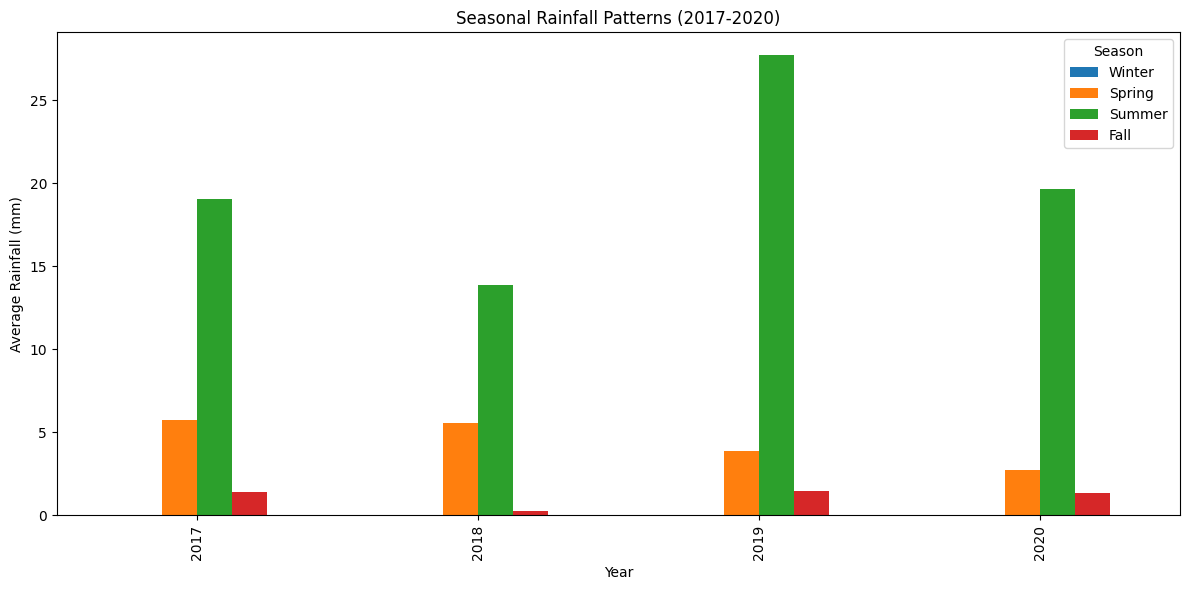

Plots have been saved as PNG files.


In [29]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you've already loaded and combined your data as 'df'
# Make sure 'TIME' is in datetime format
df['TIME'] = pd.to_datetime(df['TIME'])

# 1. Time series plot with yearly average
plt.figure(figsize=(15, 6))
yearly_avg = df.groupby(df['TIME'].dt.to_period('Y'))['RAINFALL'].mean()
yearly_avg.plot(marker='o')
plt.title('Yearly Average Rainfall (2017-2020)')
plt.xlabel('Year')
plt.ylabel('Average Rainfall (mm)')
plt.tight_layout()
plt.show()
plt.savefig('yearly_rainfall_timeseries.png')
plt.close()


# 3. Box plot of rainfall distribution by month and year
df['Year'] = df['TIME'].dt.year
df['Month'] = df['TIME'].dt.month_name()
plt.figure(figsize=(15, 8))
sns.boxplot(x='Month', y='RAINFALL', hue='Year', data=df, 
            order=['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December'])
plt.title('Rainfall Distribution by Month and Year (2017-2020)')
plt.ylabel('Rainfall (mm)')
plt.xticks(rotation=45)
plt.legend(title='Year')
plt.tight_layout()
plt.show()

plt.savefig('rainfall_boxplot.png')
plt.close()


# 5. Seasonal pattern
df['Season'] = pd.cut(df['TIME'].dt.month, 
                      bins=[0, 3, 6, 9, 12], 
                      labels=['Winter', 'Spring', 'Summer', 'Fall'],
                      include_lowest=True)
seasonal_avg = df.groupby(['Year', 'Season'])['RAINFALL'].mean().unstack()
seasonal_avg.plot(kind='bar', figsize=(12, 6))
plt.title('Seasonal Rainfall Patterns (2017-2020)')
plt.xlabel('Year')
plt.ylabel('Average Rainfall (mm)')
plt.legend(title='Season')
plt.tight_layout()
plt.show()

plt.savefig('seasonal_rainfall.png')
plt.close()

print("Plots have been saved as PNG files.")

In [40]:
data = df[["LATITUDE", "LONGITUDE"]].iloc[0:10]

d:\FloodAihackthon\.venvv\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
d:\FloodAihackthon\.venvv\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
d:\FloodAihackthon\.venvv\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
d:\FloodAihackthon\.venvv\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


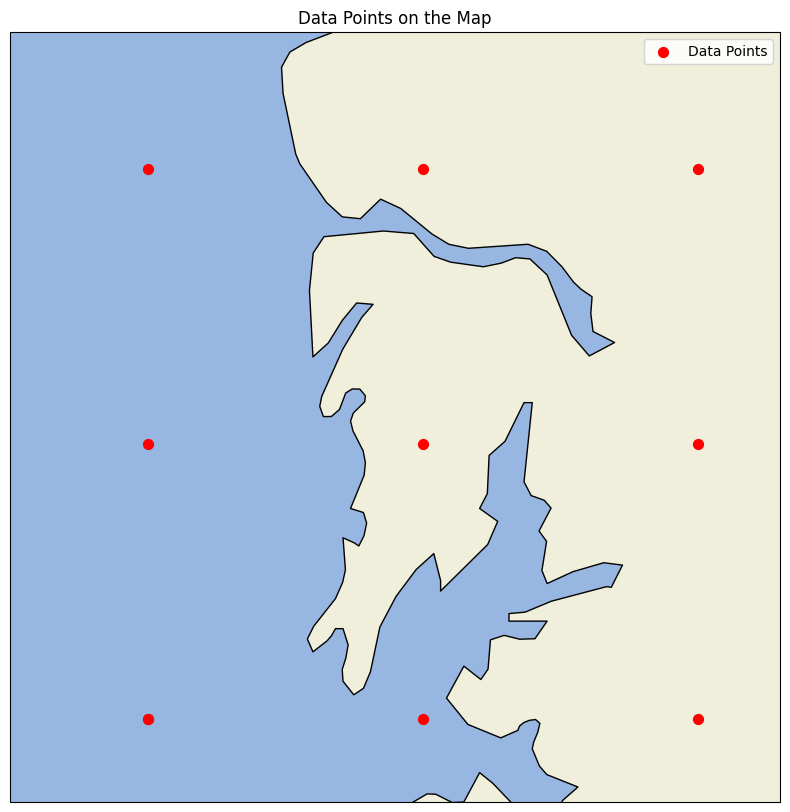

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define your data as a DataFrame
data = {
    'LATITUDE': [18.875, 18.875, 18.875, 19.125, 19.125, 19.125, 19.375, 19.375, 19.375, 18.875],
    'LONGITUDE': [72.625, 72.875, 73.125, 72.625, 72.875, 73.125, 72.625, 72.875, 73.125, 72.625]
}

# Convert the data to a pandas DataFrame
df = pd.DataFrame(data)

# Function to plot the points on a map
def plot_points(latitudes, longitudes):
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Add geographical features
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    
    # Scatter plot for the points
    ax.scatter(longitudes, latitudes, color='red', s=50, marker='o', label='Data Points')
    
    # Set extent (bounding box for the map) - Adjust these coordinates for your region
    ax.set_extent([72.5, 73.2, 18.8, 19.5], crs=ccrs.PlateCarree())
    
    plt.title('Data Points on the Map')
    plt.legend()
    plt.show()

# Call the plotting function with your data
plot_points(df['LATITUDE'], df['LONGITUDE'])


In [43]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd

In [46]:
file_path = 'combined_rainfall_data.csv'
rainfall_data = pd.read_csv(file_path)

In [48]:
rainfall_data['RAINFALL'].fillna(0, inplace=True)
rainfall_data['TIME'] = pd.to_datetime(rainfall_data['TIME'])



C:\Users\dsmat\AppData\Local\Temp\ipykernel_25072\124190808.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rainfall_data['RAINFALL'].fillna(0, inplace=True)


In [49]:
grouped_data = rainfall_data.groupby('TIME')['RAINFALL'].mean().reset_index()


In [50]:
scaler = MinMaxScaler()
rainfall_scaled = scaler.fit_transform(grouped_data['RAINFALL'].values.reshape(-1, 1))


In [52]:
def create_sequences(data, sequence_length):
    sequences, labels = [], []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [53]:
sequence_length = 30
X, y = create_sequences(rainfall_scaled, sequence_length)


In [57]:
X = X.reshape((X.shape[0], X.shape[1], 1))


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [59]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1)
])

ValueError: object __array__ method not producing an array